In [1]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.kernels import get_f_Kkappa, get_f_KI, get_f_KILo, apply_window

In [2]:
# CCAT-Prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 #deg^2

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

Pei = 5.7e4 #Jy / sr CCAT-prime

In [3]:
log2=14

In [4]:
Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_chi_sample_%d.npy'%(zmin, zmax, log2)
I_kappa = np.load(Ik_fname)
vb = np.max(np.abs(I_kappa))

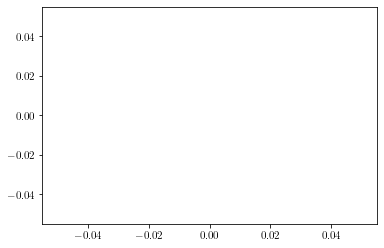

In [135]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "11"
})

In [136]:
Lambdas[0]

1e-05

In [137]:
Lambdas[6]

0.0001

In [138]:
Lambdas[12]

0.001

In [139]:
Lambdas[18]

0.01

In [140]:
Lambdas[24]

0.1

In [141]:
log_ymin = np.log10(ells[0])
log_ymax = np.log10(ells[-1])


In [142]:
plot_Lambdas = np.arange(25)[::6]


In [151]:
# fig, axs = plt.subplots(nrows = 3,
#                         ncols = 2, figsize = (6, 8), sharex=True,
#                         sharey=True, facecolor = 'w', dpi = 300)


fig, axs = plt.subplots(nrows=1, ncols=5,figsize = (6, 2), facecolor = 'w', dpi = 3000)

plt.tight_layout(pad = 0.5)
plt.subplots_adjust(wspace =0)

axs = axs.flatten()

def plot(ax, data, vminmax, Lambda):
    im = ax.imshow(data.T, 
               origin='lower',
              cmap = 'seismic',
              vmin = -vminmax,
              vmax =  vminmax,
               aspect = (log_ymin - log_ymax)/(chimin-chimax) * 1000,
              extent=[log_ymin, log_ymax, chimin/1000, chimax/1000, ])

    ax.set_title(r'$$\Lambda^{-1} = 10^{%d}\ {\rm Mpc}$$'%(-np.log10(Lambda)),fontsize=10)
    
for Lambda_idx in plot_Lambdas:
    Lambda = Lambdas[Lambda_idx]

    ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_%d.npy'%(zmin, zmax, Lambda, log2)
    ILo_kappa = np.load(ILo_kappa_fname)
    IHi_kappa = I_kappa - ILo_kappa
    

    plot(axs[Lambda_idx//6], IHi_kappa.astype(np.float64), vb, Lambda=Lambda)
    
# _y = .125
# cbar_ax = fig.add_axes([.93, 0.5 - _y, 0.02, _y * 2])  # [left, bottom, width, height]

# im = axs[-1][-1].imshow(IHi_kappa, 
#                origin='lower',
#               cmap = 'seismic',
#               vmin = -vb,
#               vmax =  vb,
#                aspect = 'auto',
#               extent=[chimin, chimax, log_ymin, log_ymax])

# cbar = fig.colorbar(im, cax=cbar_ax)


plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2
# fig.text(0.00, 0.5, r'$\chi$ [Mpc]', 
#          ha='right', 
#          va='center', 
#          rotation='vertical',
#         fontsize=11)

axs[0].set_ylabel(r'$\chi$ [{\rm Gpc}]')
axs[2].set_xlabel(r'$\log_{10}(\ell)$')
# fig.text(plt_cntr, 0.15, r'$\log_{10}(\ell)$',
#          ha='center', 
#          va='top', 
#         fontsize=11)
axs[0].tick_params(axis='y', labelsize=8)
axs[0].set_yticks([7,8,9])
for i in range(len(axs)):
    axs[i].tick_params(axis='x', labelsize=8)
    if(i > 0):
        axs[i].set_yticks([])

fig.text(plt_cntr, 1, r"\textbf{High-Pass Filtered} LIM $\times$ CMB Lensing $\langle I_{ \ell}^{\sf Hi}(\chi) \kappa_{- \ell}\rangle'$ for \texttt{CCAT-Prime}",
         ha='center', 
         va='bottom', 
        fontsize=11)

plt.savefig('figures/002.012.CCAT-prime-viz.pdf', bbox_inches='tight')